

# 🧩 General Linear Model (GLM) in fMRI

The **GLM** is the statistical workhorse in fMRI analysis.
It models the BOLD signal in each voxel (or ROI) as a linear combination of predictors plus error:

$$
Y = X \beta + \varepsilon
$$

* **Y** = measured BOLD time series (one voxel or ROI).
* **X** = design matrix (predictors, e.g., task conditions, nuisance regressors).
* **β (betas)** = estimated contribution (activation strength) of each predictor.
* **ε** = residual error (noise not explained by model).

**Why GLM?**

* It allows us to test hypotheses about brain responses to stimuli or tasks.
* By forming **contrasts** (linear combinations of betas), we obtain **statistical maps** highlighting regions engaged in specific processes.

---

# 🧩 First-Level Analysis

* **What it is:** GLM applied to **one subject, one run/session**.
* **Purpose:** Estimate how that subject’s brain responds to experimental conditions.
* **Inputs:** Preprocessed fMRI data, design matrix (task events convolved with HRF, confounds).
* **Outputs:**

  * **Beta maps:** weight of each condition at each voxel.
  * **Contrast maps (Z/t-maps):** e.g., condition A > condition B.

**Position in pipeline:**

* Comes right after preprocessing and design matrix construction.
* First-level results are the **raw material** for group-level analysis.

---

# 🧩 Second-Level Analysis

* **What it is:** GLM applied across **multiple subjects**.
* **Purpose:** Test population-level hypotheses, generalize findings.
* **Steps:**

  * Gather contrast maps from each subject (e.g., A > B).
  * Perform one-sample t-test (if testing activation across subjects).
  * Or two-sample t-test, paired t-test, ANOVA, regression (if comparing groups/conditions).
* **Outputs:**

  * Group statistical maps.
  * Inferences about brain activation at the population level.

**Position in pipeline:**

* After first-level results are computed for each subject.
* Needed if your goal is **group studies** rather than single-subject demonstration.

---

# 🧩 Relation to Functional Connectivity

Functional connectivity is **different but complementary** to GLM-based activation analysis.

* **GLM / First-Level:**

  * Answers: *“Where in the brain does activity increase/decrease with task conditions?”*
  * Focus = *mean activation differences*.

* **Functional Connectivity:**

  * Answers: *“Which regions’ time courses fluctuate together?”*
  * Focus = *relationships between regions, not absolute activity*.

* **Second-Level GLM (Group FC):**

  * We can also perform **group inference on connectivity values**.
  * Example: ROI-to-ROI Fisher-Z matrices → compare across subjects using a group-level GLM.
  * Or voxelwise seed maps → second-level GLM across subjects.

---

# 🧩 Pipeline Position (Activation vs Connectivity)

Here’s how the pieces fit together in your notebook:

1. **Preprocessing & Confounds** → clean BOLD.
2. **First-Level GLM (per subject)**

   * Fit model, build contrasts, produce activation maps.
   * Output: Z-maps per subject/condition.
3. **Second-Level GLM (group-level)**

   * Combine subject-level contrasts.
   * Output: population-level activation maps.
4. **Functional Connectivity**

   * Compute correlations (ROI-to-ROI, seed-to-voxel) on denoised signals.
   * Task FC options: Beta-series GLM or PPI.
5. **Second-Level FC**

   * Group-level stats on connectivity (e.g., is group A > group B in connectivity between ROI X and Y?).

---

✅ **Take-home message:**

* **First-level GLM** = within-subject modeling.
* **Second-level GLM** = between-subject (group/population) modeling.
* **Functional connectivity** sits alongside GLM activation analysis, focusing on *correlations*, not *mean activations*.
* Both can be combined: e.g., use GLM contrasts to define seeds → test connectivity; or use PPI (GLM extension) to probe task-modulated connectivity.

---





# 🧩 First-Level GLM Pipeline: From Preprocessed fMRI to Contrast Maps

## **🧮 GLM: What It Is, With the Full Formula**

At the **voxel level**, the BOLD time series can be expressed as a multiple linear regression:

$$
\underbrace{Y}_{T \times 1}
=
\underbrace{X_{\text{task}}}_{T \times K}\ \underbrace{\beta_{\text{task}}}_{K \times 1}
\;+\;
\underbrace{X_{\text{conf}}}_{T \times C}\ \underbrace{\beta_{\text{conf}}}_{C \times 1}
\;+\;
\underbrace{D}_{T \times P}\ \underbrace{\beta_D}_{P \times 1}
\;+\;
\varepsilon
$$

**Terms explained:**

* **$Y$**: observed fMRI time series (length = number of scans $T$).
* **$X_{\text{task}}$**: design matrix columns for experimental conditions (built from events and **convolved with the HRF**).
* **$X_{\text{conf}}$**: nuisance regressors (motion, WM/CSF, scrubbing spikes, aCompCor, etc.).
* **$D$**: drift terms (cosine basis for high-pass filtering, typically auto-added in GLM).
* **$\beta_{\text{task}}$**: activation weights → **what we care about** (condition effects).
* **$\beta_{\text{conf}}, \beta_D$**: nuisance weights → absorb variance so task betas aren’t biased.
* **$\varepsilon$**: residual error. Nilearn models autocorrelation with an AR(1) process.

### 🧠 **What happens across voxels?**

The GLM is solved **independently** for each voxel:

* design matrix (X) is fixed
* β is re-estimated for every voxel

So internally the software computes:

$$
\beta = (X^T X)^{-1} X^T Y
$$



but separately for **each voxel's Y**.

### 🧩 Contrasts (Hypothesis Testing)

Once betas are estimated, we test hypotheses using **contrasts**:

$$
c^\top \hat\beta
$$

* $c$ = contrast vector (e.g., `[1, -1, 0, 0, ...]`)
* $\hat\beta$ = estimated betas for all regressors.

The contrast value is divided by its standard error to produce a **t- or z-statistic**:

$$
Z = \frac{c^\top \hat\beta}{\mathrm{SE}(c^\top \hat\beta)}
$$

Examples:

* **Condition vs baseline:** `congruent > 0` → $c=[1,0,0,...]$
* **Condition A vs B:** `incongruent > congruent` → $c=[1,-1,0,...]$

This yields **contrast maps** (Z-maps, beta maps, effect-size maps).

---

##  ⚙️ Practical Steps to Run First-Level GLM in Nilearn

### Step 1. Prepare Inputs

**What:** Preprocessed fMRI image (`func.nii.gz`), events table (`onset`, `duration`, `trial_type`), TR, and a confounds table aligned to scans.

**Why:** The GLM needs a clean time series, the task timing, and nuisance regressors to remove noise.

**Checks:** number of scans in confounds = number of volumes; onsets/durations in **seconds**.

---

### Step 2. Build the Design Matrix

**What:** Turn events into task regressors by **convolving with the HRF** and add **low-frequency drift** regressors.

**How (concept):** `make_first_level_design_matrix(frame_times, events, hrf_model='spm', drift_model='cosine', high_pass=0.008)`

**Why:** HRF models the delayed BOLD response; drift terms capture scanner slow trends.

**Checks:** plot the matrix; task columns should show smooth HRF “bumps”; no NaNs.

---
### Step 3. Add confounds (nuisance regressors)

**What:** Motion (e.g., **24HMP**), WM/CSF (or aCompCor), scrubbing spikes (FD/DVARS), plus any global/physio terms you use.

**How (concept):** pass a DataFrame/array to `fit(..., confounds=conf_df)`; do **not** insert confounds into the events.

**Why:** Removing noise improves SNR and prevents bias in task betas.

**Checks:** confound columns are numeric, scan-aligned, and free of NaNs.

* Join with confounds → final regressors for the model.
* ✅ QC: plot the design matrix to verify conditions + confounds are correct.

---

### Step 4. Fit the GLM (FirstLevelModel)

**What:** Create and fit `FirstLevelModel` per run.

**How (concept):**

```python
model = FirstLevelModel(
    t_r=TR, hrf_model='spm',
    drift_model='cosine', high_pass=0.008,
    noise_model='ar1'
)
model = model.fit(func_img, events=events, confounds=confounds_df)
```

**Why:** Estimates **betas** (effect sizes) and the residual variance voxel-wise.

**Checks:** inspect `model.design_matrices_[0].columns`; verify task regressors are present.

* At this step, Nilearn estimates **betas** for every regressor.

---

### Step 5. Define Contrasts (After Fitting) → compute & threshold maps

**What:** Name contrasts (e.g., `"incongruent - congruent"`, or vectors aligned to the design columns) and get **z/t/beta** maps.

* Contrasts reference **column names** in the design matrix.
* Example:

```python
contrast_matrix = {
    "incongruent>baseline": np.array([1, 0, 0, ...]),
    "incongruent>congruent": np.array([1, -1, 0, ...]),
}
```

**How (concept):**

* Pass to `model.compute_contrast(...)`.

* `zmap = model.compute_contrast("A - B", output_type='z_score')`

* Threshold: `thr_img, thr = threshold_stats_img(zmap, alpha=0.05, height_control='fdr')` *(or cluster thresholding)*

* Visualize: `plot_stat_map(thr_img, title='A>B (FDR<0.05)')`

  **Why:** Contrasts test hypotheses; thresholding controls multiple comparisons.
  
  **Checks:** report threshold method (FDR/FWE/cluster), cut coordinates, and show both **unthresholded** (for QC) and **thresholded** maps.


✅ **Summary:**

* **Fit first, contrast later**.
* Contrasts = linear tests of betas.
* Outputs: **beta maps (effect sizes)** and **z/t maps (statistical significance)**.
* Thresholding makes inference reliable across the whole brain.



> Tip: With multiple runs, compute the same contrast per run, then combine using **fixed effects** (`compute_fixed_effects`) before visualization or group-level analysis.


---


# **🧱 Confounds vs. Regressors (what & why)**

In fMRI GLM analysis, the **design matrix** is built from two families of predictors:



## 🎯 Regressors of Interest (Task Regressors)

* These are the predictors that **model your experimental manipulations** (e.g., *congruent* vs. *incongruent* trials).
* They are built from your **`events.tsv`** file containing:

  * **Onset** (when the event starts, in seconds)
  * **Duration** (how long it lasts)
  * **Trial type** (condition label)

### 🔄 HRF Convolution

Because the BOLD signal is **delayed and blurred relative to neural activity**, event predictors are **convolved with the HRF (Hemodynamic Response Function):**

* **HRF** is a canonical impulse response that peaks \~5s after a neural event and undershoots \~15s.
* Nilearn options: `'spm'`, `'glover'`, `'fir'`, or custom shapes.
* Choosing the HRF model affects sensitivity:

  * `'spm'` (two-gamma) ≈ standard in SPM software.
  * `'glover'` ≈ default in FSL.
  * `'fir'` = Finite Impulse Response → estimates shape directly, no HRF assumption.

👉 These **task regressors** (after convolution) go into the **design matrix** and produce **beta estimates** → later combined into **contrasts** → **activation maps**.



## 🧱 Confounds (Nuisance Regressors)

Confounds are predictors that **explain variance not due to the task**. Including them reduces bias and increases statistical power (SNR).

### Common confound categories:

1. **Motion parameters**

   * 6 rigid-body realignment parameters (x, y, z translations + pitch, roll, yaw rotations).
   * Expanded to **24HMP** = 6 + derivatives + squares + squared derivatives.
   * Captures head motion artifacts.

2. **Physiological noise regressors**

   * **WM/CSF mean signals**: average signal in white matter and cerebrospinal fluid masks.
   * **aCompCor components**: PCA-derived regressors from WM/CSF masks.
   * Help reduce respiratory and cardiac fluctuations.

3. **Outlier regressors (scrubbing)**

   * One-hot regressors for frames with **high framewise displacement (FD)** or **high DVARS**.
   * Protects against motion spikes.

4. **Drift terms**

   * Low-frequency scanner drifts handled with high-pass filters.
   * Nilearn’s `drift_model="cosine"` automatically adds cosine regressors.

5. **Optional: Global signal**

   * Mean signal across all brain voxels.
   * Controversial: can reduce widespread noise but may remove true neural variance.
   * If used, must be **explicitly justified and reported**.

---

## 🛠 Where they live in Nilearn

* **Task regressors** → built inside the **design matrix** with

  ```python
  make_first_level_design_matrix(frame_times, events, hrf_model="spm", ...)
  ```

* **Confounds** → passed separately when fitting the GLM:

  ```python
  model = FirstLevelModel(...).fit(func_img, events=events, confounds=confounds_df)
  ```

* **For connectivity** → confounds are regressed out when extracting time series with maskers:

  ```python
  masker = NiftiMasker(...).fit_transform(func_img, confounds=confounds_df)
  ```

---

✅ **Take-home:**

* **Regressors of interest** = *signal you care about* (task → activation maps).
* **Confounds** = *noise you want to remove* (motion, physiology, drift, spikes).
* Together, they ensure your GLM produces **valid contrasts** and your connectivity analysis is **not driven by artifacts**.

---




# **✅) Load preproccessed images & events**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib

from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.glm import thresholding
from nilearn.glm.contrasts import compute_fixed_effects
from nilearn import plotting
from nilearn.plotting import plot_contrast_matrix

##  paths
run1_path   = r"H:\ML.neuroimaging\teaching\S 11\flanker\sub-02_task-flanker_run-1_bold.nii\swarsub-02_task-flanker_run-1_bold.nii"
run2_path   = r"H:\ML.neuroimaging\teaching\S 11\flanker\sub-02_task-flanker_run-2_bold.nii\swarsub-02_task-flanker_run-2_bold.nii"

event1_path = r"H:\ML.neuroimaging\teaching\S 11\flanker\sub-02_task-flanker_run-1_bold.nii\sub-02_func_sub-02_task-flanker_run-1_events.tsv"
event2_path = r"H:\ML.neuroimaging\teaching\S 11\flanker\sub-02_task-flanker_run-2_bold.nii\sub-02_func_sub-02_task-flanker_run-2_events.tsv"


img1 = nib.load(run1_path)
img2 = nib.load(run2_path)

ev1  = pd.read_csv(event1_path, sep="\t")
ev2  = pd.read_csv(event2_path, sep="\t")

assert {'onset','duration','trial_type'}.issubset(ev1.columns)
assert {'onset','duration','trial_type'}.issubset(ev2.columns)

TR1 = float(img1.header.get_zooms()[3])
TR2 = float(img2.header.get_zooms()[3])

n_scans_1 = img1.shape[-1]
n_scans_2 = img2.shape[-1]

frame_times_1 = np.arange(n_scans_1) * TR1
frame_times_2 = np.arange(n_scans_2) * TR2

print("TR1, TR2:", TR1, TR2)
print("n_scans_1, n_scans_2:", n_scans_1, n_scans_2)
ev1.head()


TR1, TR2: 2.0 2.0
n_scans_1, n_scans_2: 146 146


,onset,duration,trial_type,response_time,correctness,StimVar,Rsponse,Stimulus,cond
0,0.0,2.0,congruent_correct,0.510,correct,1,1,congruent,cond001
1,10.0,2.0,incongruent_correct,0.864,correct,2,1,incongruent,cond003
2,20.0,2.0,congruent_correct,0.540,correct,1,1,congruent,cond001
3,30.0,2.0,incongruent_correct,0.863,correct,2,1,incongruent,cond003
4,40.0,2.0,incongruent_correct,0.746,correct,2,1,incongruent,cond003


In [ ]:
ev2.head()

,onset,duration,trial_type,response_time,correctness,StimVar,Rsponse,Stimulus,cond
0,0.0,2.0,incongruent_correct,0.763,correct,1,1,congruent,cond003
1,10.0,2.0,incongruent_correct,0.613,correct,2,1,incongruent,cond003
2,20.0,2.0,incongruent_correct,0.737,correct,1,1,congruent,cond003
3,32.0,2.0,incongruent_correct,0.869,correct,2,1,incongruent,cond003
4,44.0,2.0,congruent_correct,0.647,correct,2,1,incongruent,cond001


---

## **Step 1 — build **confounds** , **manual 24HMP** from SPM realignment (only if you **don’t** have fMRIPrep)**


### 📐 What are the columns in an `rp_*.txt` file?

These files contain the **estimated head motion parameters** from realignment (motion correction).
They always have **6 columns**, in the following order:

1. **trans\_x** → translation along the X-axis (left–right), in millimeters.
2. **trans\_y** → translation along the Y-axis (anterior–posterior), in millimeters.
3. **trans\_z** → translation along the Z-axis (inferior–superior), in millimeters.
4. **rot\_x** → rotation around the X-axis (pitch, nodding motion), in radians.
5. **rot\_y** → rotation around the Y-axis (roll, tilting motion), in radians.
6. **rot\_z** → rotation around the Z-axis (yaw, shaking head “no”), in radians.



### 📊 Why are these important?

* Head motion is one of the **biggest confounds** in fMRI.
* Even sub-millimeter translations or small rotations can create spurious correlations across brain regions.
* That’s why these parameters (and their derivatives/squares = **24HMP**) are typically included as **confound regressors** in the GLM and connectivity analysis.



### 🛠️ How they’re used

* **Direct regressors:** put the 6 motion parameters in the design matrix.
* **Expanded (24HMP):**

  * Original 6 parameters.
  * Their temporal derivatives (differences from volume to volume).
  * Their squared values.
  * Derivatives squared.
* This expansion captures more subtle, nonlinear motion effects.

---


Your `rp_*.txt` file is the raw motion record: 3 translations (mm) + 3 rotations (radians). They form the basis for motion confounds in your design matrix.




In [2]:
rp1_path = r"H:\ML.neuroimaging\teaching\S 11\flanker\sub-02_task-flanker_run-1_bold.nii\rp_sub-02_task-flanker_run-1_bold.txt"
rp2_path = r"H:\ML.neuroimaging\teaching\S 11\flanker\sub-02_task-flanker_run-2_bold.nii\rp_sub-02_task-flanker_run-2_bold.txt"

# Load raw 6 motion params (SPM format)
mp1 = pd.read_csv(rp1_path, sep=r"\s+", header=None)
mp2 = pd.read_csv(rp2_path, sep=r"\s+", header=None)

mp1.columns = ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']
mp2.columns = ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']

# Temporal derivatives (first difference)
deriv1 = mp1.diff().fillna(0); deriv1.columns = [c + '_derivative1' for c in mp1.columns]
deriv2 = mp2.diff().fillna(0); deriv2.columns = [c + '_derivative1' for c in mp2.columns]

# Squares of originals and derivatives
p2_1 = (mp1**2); p2_1.columns = [c + '_power2' for c in mp1.columns]
p2_2 = (mp2**2); p2_2.columns = [c + '_power2' for c in mp2.columns]

d2_1 = (deriv1**2); d2_1.columns = [c + '_power2' for c in deriv1.columns]
d2_2 = (deriv2**2); d2_2.columns = [c + '_power2' for c in deriv2.columns]

# Concatenate → 24HMP
conf1 = pd.concat([mp1, deriv1, p2_1, d2_1], axis=1)
conf2 = pd.concat([mp2, deriv2, p2_2, d2_2], axis=1)

# Coerce numeric strictly (anything non-numeric becomes NaN)
conf1 = conf1.apply(pd.to_numeric, errors='coerce')
conf2 = conf2.apply(pd.to_numeric, errors='coerce')

# PAD to match image length (fill missing rows with 0s)
n_scans_1 = img1.shape[-1]
n_scans_2 = img2.shape[-1]

conf1 = conf1.reindex(range(n_scans_1)).fillna(0).reset_index(drop=True)
conf2 = conf2.reindex(range(n_scans_2)).fillna(0).reset_index(drop=True)

print("conf1 shape:", conf1.shape, "NaNs:", int(conf1.isna().to_numpy().sum()))
print("conf2 shape:", conf2.shape, "NaNs:", int(conf2.isna().to_numpy().sum()))
conf1.head(3)

conf1 shape: (146, 24) NaNs: 0
conf2 shape: (146, 24) NaNs: 0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,trans_x_derivative1,trans_y_derivative1,trans_z_derivative1,rot_x_derivative1,...,trans_z_power2,rot_x_power2,rot_y_power2,rot_z_power2,trans_x_derivative1_power2,trans_y_derivative1_power2,trans_z_derivative1_power2,rot_x_derivative1_power2,rot_y_derivative1_power2,rot_z_derivative1_power2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,0.017953,-0.002970,0.023004,-0.000383,0.000308,0.000124,0.017953,-0.002970,0.023004,-0.000383,...,0.000529,1.468272e-07,9.475147e-08,1.536598e-08,0.000322,0.000009,0.000529,1.468272e-07,9.475147e-08,1.536598e-08
2,0.009020,0.045421,0.054231,0.000892,0.000039,0.000180,-0.008933,0.048391,0.031228,0.001275,...,0.002941,7.952523e-07,1.533728e-09,3.253289e-08,0.000080,0.002342,0.000975,1.625497e-06,7.217520e-08,3.181994e-09


In [ ]:
conf2.head(3)

,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,trans_x_derivative1,trans_y_derivative1,trans_z_derivative1,rot_x_derivative1,...,trans_z_power2,rot_x_power2,rot_y_power2,rot_z_power2,trans_x_derivative1_power2,trans_y_derivative1_power2,trans_z_derivative1_power2,rot_x_derivative1_power2,rot_y_derivative1_power2,rot_z_derivative1_power2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,0.041842,0.089176,0.027571,0.001662,0.000041,0.000391,0.041842,0.089176,0.027571,0.001662,...,0.000760,0.000003,1.640633e-09,1.528053e-07,0.001751,0.007952,0.000760,2.762220e-06,1.640633e-09,1.528053e-07
2,0.102046,0.215134,0.030296,0.001106,0.000529,0.000935,0.060204,0.125958,0.002725,-0.000556,...,0.000918,0.000001,2.797418e-07,8.749073e-07,0.003625,0.015865,0.000007,3.096629e-07,2.385360e-07,2.964385e-07


---

## **Step 2 & 3 — Build design matrices (task regressors + drifts) and join confounds (per run)**

Run1 trial_type levels: ['congruent' 'incongruent']
Run2 trial_type levels: ['congruent' 'incongruent']


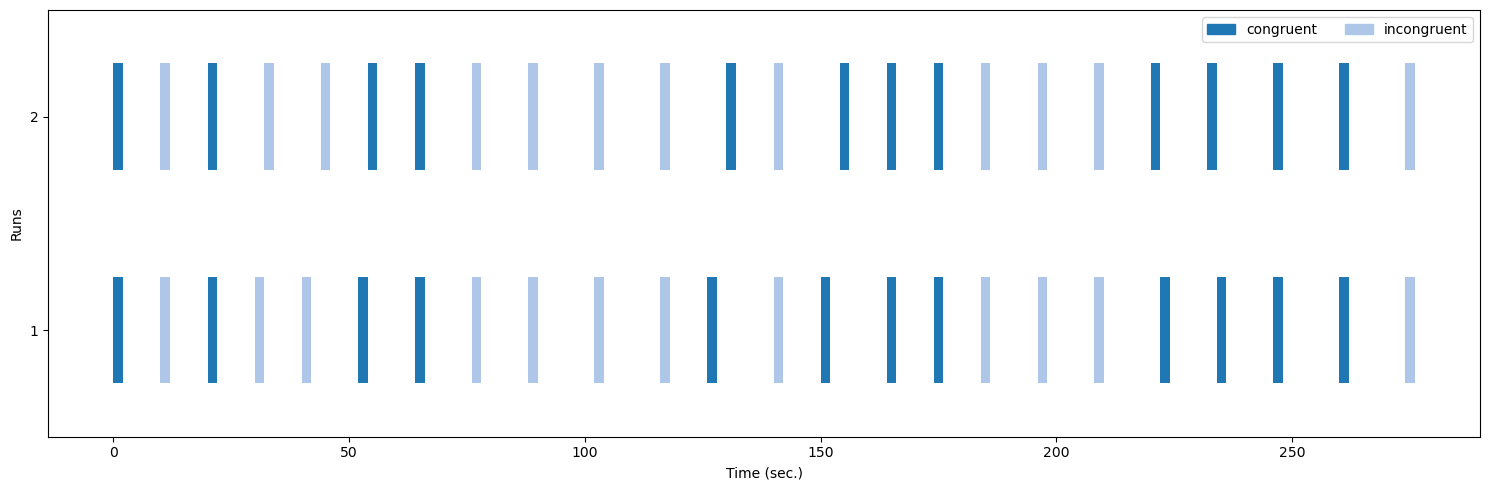

In [6]:
events1_clean = pd.DataFrame({
    'onset':    ev1['onset'].astype(float).values,
    'duration': ev1['duration'].astype(float).values if 'duration' in ev1.columns else np.ones(len(ev1))*1.0,
    'trial_type': ev1['Stimulus'].astype(str).str.strip().str.lower().values  # -> congruent / incongruent
}).sort_values('onset').reset_index(drop=True)

events2_clean = pd.DataFrame({
    'onset':    ev2['onset'].astype(float).values,
    'duration': ev2['duration'].astype(float).values if 'duration' in ev2.columns else np.ones(len(ev2))*1.0,
    'trial_type': ev2['Stimulus'].astype(str).str.strip().str.lower().values
}).sort_values('onset').reset_index(drop=True)

print("Run1 trial_type levels:", events1_clean['trial_type'].unique())
print("Run2 trial_type levels:", events2_clean['trial_type'].unique())

plotting.plot_event([events1_clean, events2_clean] , figsize = (15,5))
plt.show()

In [3]:
n_scans_1 = img1.shape[-1]
n_scans_1

146

In [4]:
frame_times_1 = np.arange(n_scans_1) * TR1
frame_times_1

array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
        22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
        44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
        66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
        88.,  90.,  92.,  94.,  96.,  98., 100., 102., 104., 106., 108.,
       110., 112., 114., 116., 118., 120., 122., 124., 126., 128., 130.,
       132., 134., 136., 138., 140., 142., 144., 146., 148., 150., 152.,
       154., 156., 158., 160., 162., 164., 166., 168., 170., 172., 174.,
       176., 178., 180., 182., 184., 186., 188., 190., 192., 194., 196.,
       198., 200., 202., 204., 206., 208., 210., 212., 214., 216., 218.,
       220., 222., 224., 226., 228., 230., 232., 234., 236., 238., 240.,
       242., 244., 246., 248., 250., 252., 254., 256., 258., 260., 262.,
       264., 266., 268., 270., 272., 274., 276., 278., 280., 282., 284.,
       286., 288., 290.])

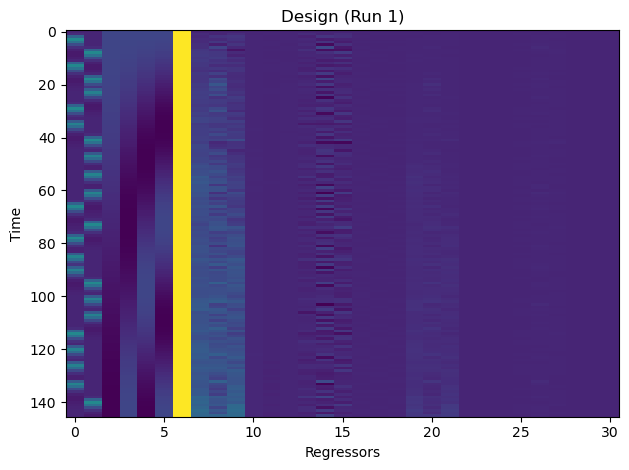

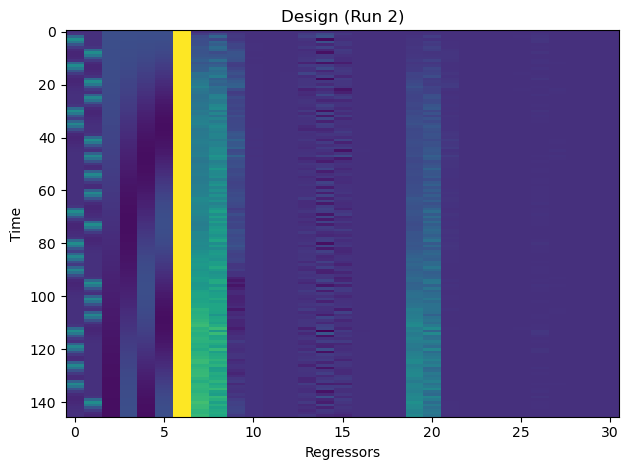

In [7]:
# Design with task + drifts
dm_task1 = make_first_level_design_matrix(frame_times_1, events1_clean,
                                          hrf_model='spm', drift_model='cosine', high_pass=0.008).reset_index(drop=True)
dm_task2 = make_first_level_design_matrix(frame_times_2, events2_clean,
                                          hrf_model='spm', drift_model='cosine', high_pass=0.008).reset_index(drop=True)

# Concatenate side-by-side (avoids join index issues), coerce numeric, fill NaNs → 0
dm1 = pd.concat([dm_task1, conf1], axis=1)
dm2 = pd.concat([dm_task2, conf2], axis=1)

dm1 = dm1.apply(pd.to_numeric, errors='coerce').fillna(0)
dm2 = dm2.apply(pd.to_numeric, errors='coerce').fillna(0)

plt.imshow(dm1.to_numpy(dtype=float), aspect='auto', interpolation='nearest')
plt.title('Design (Run 1)'); plt.xlabel('Regressors'); plt.ylabel('Time'); plt.tight_layout(); plt.show()

plt.imshow(dm2.to_numpy(dtype=float), aspect='auto', interpolation='nearest')
plt.title('Design (Run 2)'); plt.xlabel('Regressors'); plt.ylabel('Time'); plt.tight_layout(); plt.show()




### How to read the design matrix plots

* **Rows = timepoints (scans)** → top = beginning of run, bottom = end of run.
* **Columns = regressors (predictors)** → each column is one variable the GLM will model.
* **Color = value of regressor at that time** → purple/blue = low, green/yellow = high.

---

### What the columns mean

1. **First 2 columns (left side):** your **task regressors** (`congruent`, `incongruent`), convolved with the HRF. They look like smooth bumps repeating whenever a trial occurred.
2. **Bright yellow column around \~6:** the **constant (intercept)** regressor, always “on”.
3. **Next block (middle area):** the **motion confounds** (translations/rotations, derivatives, squared terms). They look more irregular, small spikes where the subject moved.
4. **Rightmost columns:** **cosine drift terms** from high-pass filtering. They wiggle slowly over time to remove scanner drifts and very low-frequency noise.

---

### What it tells you

* You now have **task effects + nuisance regressors** in the same model.
* The GLM will estimate how much variance in each voxel’s BOLD signal is explained by your task (congruent vs incongruent), after accounting for motion and drifts.
* This balanced setup is exactly what you want before computing contrasts (like *incongruent > congruent*).

---



## **Step 4 — Fit the GLM per run**

```python
class nilearn.glm.first_level.FirstLevelModel(t_r=None, slice_time_ref=0.0, hrf_model='glover', drift_model='cosine', high_pass=0.01,

                                                drift_order=1, fir_delays=None, min_onset=-24, mask_img=None, target_affine=None, target_shape=None, smoothing_fwhm=None,
 
                                                  memory=None, memory_level=1, standardize=False, signal_scaling=0, noise_model='ar1', verbose=0, n_jobs=1, minimize_memory=True,

                                                    subject_label=None, random_state=None)
```

In [9]:
# Instantiate models (per run)
model1 = FirstLevelModel(t_r=TR1, hrf_model='spm', drift_model='cosine',
                         high_pass=0.008, noise_model='ols',
                         standardize=False, signal_scaling=False)

model2 = FirstLevelModel(t_r=TR2, hrf_model='spm', drift_model='cosine',
                         high_pass=0.008, noise_model='ols',
                         standardize=False, signal_scaling=False)

# Fit with events + confounds
model1 = model1.fit(img1, events=events1_clean, confounds=conf1)
model2 = model2.fit(img2, events=events2_clean, confounds=conf2)
model1



,t_r,2.0
,slice_time_ref,0.0
,hrf_model,'spm'
,drift_model,'cosine'
,high_pass,0.008
,drift_order,1
,fir_delays,[0]
,min_onset,-24
,mask_img,None
,target_affine,None
,target_shape,None


In [10]:
pd.DataFrame(model1.design_matrices_[0])

,congruent,incongruent,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,trans_x_derivative1,trans_y_derivative1,...,trans_y_derivative1_power2,trans_z_derivative1_power2,rot_x_derivative1_power2,rot_y_derivative1_power2,rot_z_derivative1_power2,drift_1,drift_2,drift_3,drift_4,constant
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.117034,0.117014,0.116980,0.116933,1.0
2.0,0.019130,0.000000,0.017953,-0.002970,0.023004,-0.000383,0.000308,0.000124,0.017953,-0.002970,...,0.000009,0.000529,1.468272e-07,9.475147e-08,1.536598e-08,0.116980,0.116797,0.116493,0.116067,1.0
4.0,0.235975,0.000000,0.009020,0.045421,0.054231,0.000892,0.000039,0.000180,-0.008933,0.048391,...,0.002342,0.000975,1.625497e-06,7.217520e-08,3.181994e-09,0.116872,0.116364,0.115520,0.114342,1.0
6.0,0.407753,0.000000,0.018050,0.014094,0.046858,0.000643,-0.000239,0.000129,0.009030,-0.031327,...,0.000981,0.000054,6.193610e-08,7.745739e-08,2.652410e-09,0.116709,0.115716,0.114067,0.111770,1.0
8.0,0.305191,0.000000,0.019934,0.065208,0.018757,0.001140,0.000111,0.000568,0.001884,0.051114,...,0.002613,0.000790,2.475429e-07,1.227758e-07,1.927738e-07,0.116493,0.114853,0.112138,0.108371,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282.0,-0.015884,0.305191,0.225636,0.183858,0.259000,0.007580,-0.004437,0.001919,-0.016602,0.022094,...,0.000488,0.004536,8.169797e-07,3.538575e-08,1.701230e-07,-0.116493,0.114853,-0.112138,0.108371,1.0
284.0,-0.008488,0.141690,0.247124,0.116611,0.263228,0.007510,-0.003982,0.001875,0.021488,-0.067248,...,0.004522,0.000018,4.988060e-09,2.069076e-07,1.888876e-09,-0.116709,0.115716,-0.114067,0.111770,1.0
286.0,-0.004039,0.034974,0.266763,0.187306,0.272780,0.007633,-0.004104,0.002253,0.019640,0.070696,...,0.004998,0.000091,1.525568e-08,1.489574e-08,1.430232e-07,-0.116872,0.116364,-0.115520,0.114342,1.0
288.0,-0.001744,-0.017274,0.255501,0.147164,0.257765,0.008158,-0.004320,0.002004,-0.011262,-0.040142,...,0.001611,0.000225,2.752927e-07,4.658833e-08,6.221687e-08,-0.116980,0.116797,-0.116493,0.116067,1.0


### ✅ **Why are design matrix values floats instead of 0 and 1?**

Because **fMRI design matrices are *not* simple on/off (binary) indicators**.

Instead, they contain **continuous values created by convolving events with the HRF (Hemodynamic Response Function)**.

### 📌 **Why must they be floats?**

Because the GLM tries to match the *shape* of the BOLD response.
If we used only 0/1, we would falsely assume the brain responds instantly.

In [11]:
model1.get_params()

{'drift_model': 'cosine',
 'drift_order': 1,
 'fir_delays': [0],
 'high_pass': 0.008,
 'hrf_model': 'spm',
 'mask_img': None,
 'memory': Memory(location=None),
 'memory_level': 1,
 'min_onset': -24,
 'minimize_memory': True,
 'n_jobs': 1,
 'noise_model': 'ols',
 'random_state': None,
 'signal_scaling': False,
 'slice_time_ref': 0.0,
 'smoothing_fwhm': None,
 'standardize': False,
 'subject_label': None,
 't_r': 2.0,
 'target_affine': None,
 'target_shape': None,
 'verbose': 0}

In [12]:
model1.design_matrices_[0].columns.tolist()


['congruent',
 'incongruent',
 'trans_x',
 'trans_y',
 'trans_z',
 'rot_x',
 'rot_y',
 'rot_z',
 'trans_x_derivative1',
 'trans_y_derivative1',
 'trans_z_derivative1',
 'rot_x_derivative1',
 'rot_y_derivative1',
 'rot_z_derivative1',
 'trans_x_power2',
 'trans_y_power2',
 'trans_z_power2',
 'rot_x_power2',
 'rot_y_power2',
 'rot_z_power2',
 'trans_x_derivative1_power2',
 'trans_y_derivative1_power2',
 'trans_z_derivative1_power2',
 'rot_x_derivative1_power2',
 'rot_y_derivative1_power2',
 'rot_z_derivative1_power2',
 'drift_1',
 'drift_2',
 'drift_3',
 'drift_4',
 'constant']

## **Step 5A — Detect condition columns and define contrasts (order-independent)**

Run1 design columns: ['congruent', 'incongruent', 'drift_1', 'drift_2', 'drift_3', 'drift_4', 'constant', 'trans_x'] ...
Run2 design columns: ['congruent', 'incongruent', 'drift_1', 'drift_2', 'drift_3', 'drift_4', 'constant', 'trans_x'] ...
Run1 resolved: congruent incongruent
Run2 resolved: congruent incongruent
Run1 contrasts: ['congruent>baseline', 'incongruent>baseline', 'incongruent>congruent', 'congruent>incongruent']
Run2 contrasts: ['congruent>baseline', 'incongruent>baseline', 'incongruent>congruent', 'congruent>incongruent']


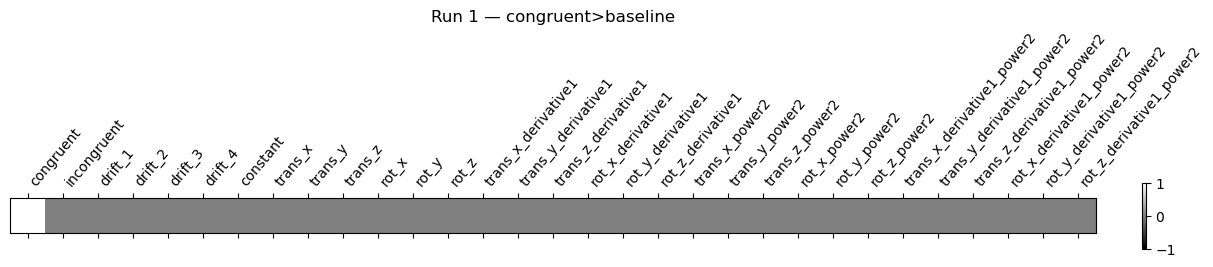

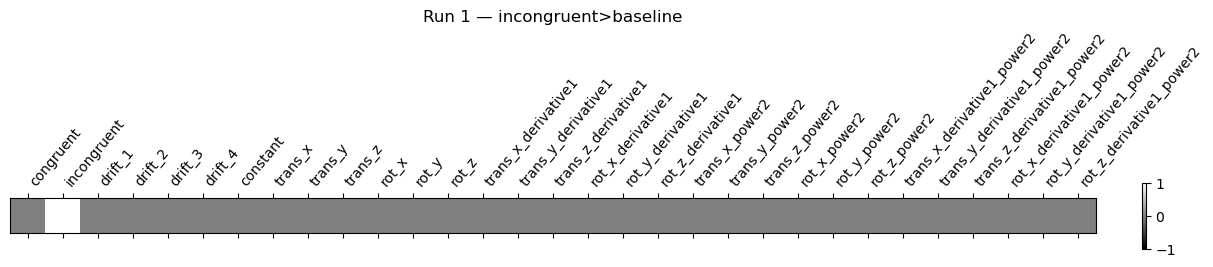

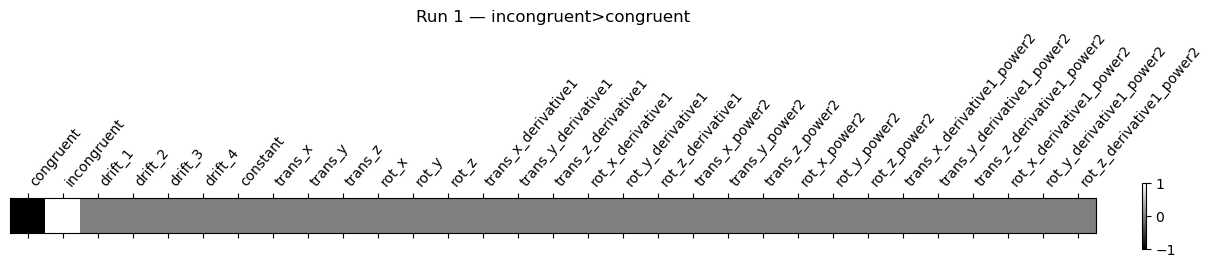

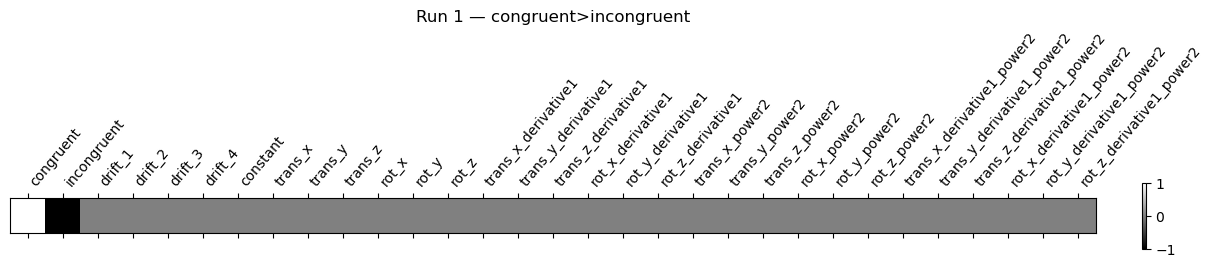

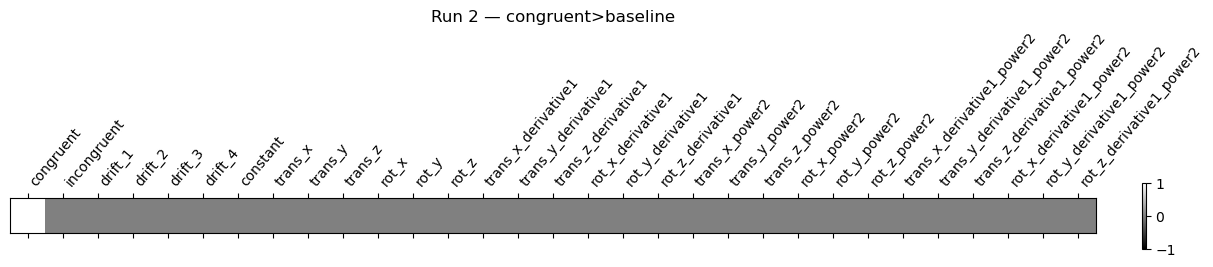

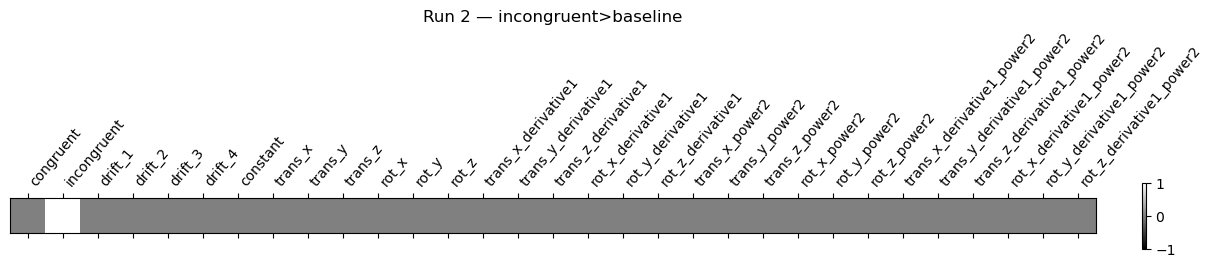

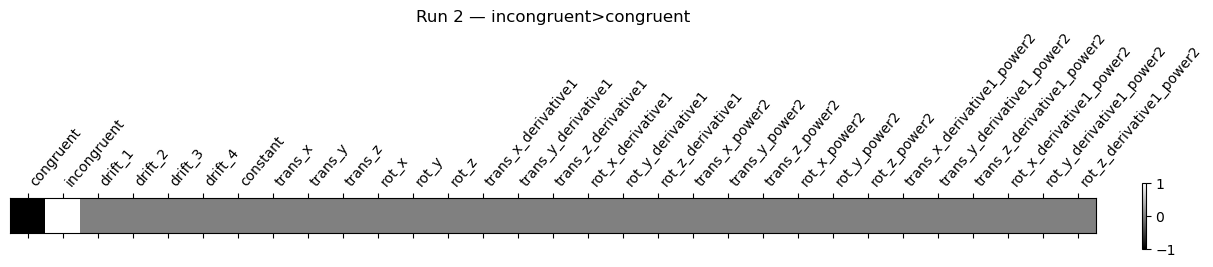

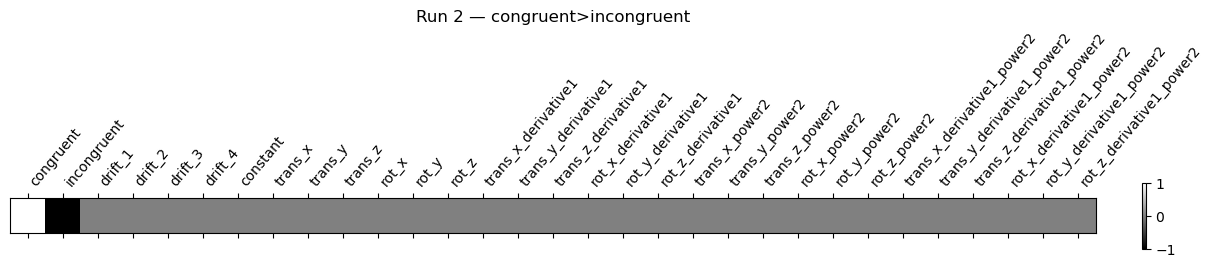

Run1 congruent>baseline non-zero: [('congruent', 1.0)]
Run1 incongruent>baseline non-zero: [('incongruent', 1.0)]
Run1 incongruent>congruent non-zero: [('congruent', -1.0), ('incongruent', 1.0)]
Run1 congruent>incongruent non-zero: [('congruent', 1.0), ('incongruent', -1.0)]
Run2 congruent>baseline non-zero: [('congruent', 1.0)]
Run2 incongruent>baseline non-zero: [('incongruent', 1.0)]
Run2 incongruent>congruent non-zero: [('congruent', -1.0), ('incongruent', 1.0)]
Run2 congruent>incongruent non-zero: [('congruent', 1.0), ('incongruent', -1.0)]


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn.plotting import plot_contrast_matrix

# --- 1) Inspect design columns (already built: dm1, dm2) ---
cols1 = list(dm1.columns)
cols2 = list(dm2.columns)
print("Run1 design columns:", cols1[:8], "...")  # peek
print("Run2 design columns:", cols2[:8], "...")

# --- 2) Resolve the actual column names for your two conditions in each run ---
# works for 'congruent' or 'trial_type_congruent' (same for 'incongruent')
def resolve(colnames, base):
    hits = [c for c in colnames if (c == base) or c.endswith("_"+base)]
    return hits[0] if len(hits) else None

r1_cong = resolve(cols1, "congruent")
r1_incg = resolve(cols1, "incongruent")
r2_cong = resolve(cols2, "congruent")
r2_incg = resolve(cols2, "incongruent")

print("Run1 resolved:", r1_cong, r1_incg)
print("Run2 resolved:", r2_cong, r2_incg)

# --- 3) Build clean contrast dictionaries (vectors aligned to design column order) ---
def contrast_vec(design_cols, weights_dict):
    v = pd.Series(0.0, index=design_cols)
    for k, w in weights_dict.items():
        if k in v.index:
            v.loc[k] = float(w)
    return v.values  # numpy 1-D

contrasts_run1 = {}
contrasts_run2 = {}

if r1_cong: contrasts_run1["congruent>baseline"] = contrast_vec(cols1, {r1_cong: +1})
if r1_incg: contrasts_run1["incongruent>baseline"] = contrast_vec(cols1, {r1_incg: +1})
if r1_cong and r1_incg:
    contrasts_run1["incongruent>congruent"] = contrast_vec(cols1, {r1_incg: +1, r1_cong: -1})
    contrasts_run1["congruent>incongruent"] = contrast_vec(cols1, {r1_cong: +1, r1_incg: -1})

if r2_cong: contrasts_run2["congruent>baseline"] = contrast_vec(cols2, {r2_cong: +1})
if r2_incg: contrasts_run2["incongruent>baseline"] = contrast_vec(cols2, {r2_incg: +1})
if r2_cong and r2_incg:
    contrasts_run2["incongruent>congruent"] = contrast_vec(cols2, {r2_incg: +1, r2_cong: -1})
    contrasts_run2["congruent>incongruent"] = contrast_vec(cols2, {r2_cong: +1, r2_incg: -1})

print("Run1 contrasts:", list(contrasts_run1.keys()))
print("Run2 contrasts:", list(contrasts_run2.keys()))

# --- 4) Visualize each contrast against its design matrix ---
for name, w in contrasts_run1.items():
    plot_contrast_matrix(w, design_matrix=dm1, colorbar=True)  # contrast passed positionally
    plt.title(f"Run 1 — {name}")
    plt.show()

for name, w in contrasts_run2.items():
    plot_contrast_matrix(w, design_matrix=dm2, colorbar=True)
    plt.title(f"Run 2 — {name}")
    plt.show()

# (optional) Quick text check of non-zero weights for transparency
def nonzero_summary(design_cols, vec):
    nz = [(c, float(vec[i])) for i, c in enumerate(design_cols) if abs(vec[i]) > 0]
    return nz

for name, w in contrasts_run1.items():
    print("Run1", name, "non-zero:", nonzero_summary(cols1, w))
for name, w in contrasts_run2.items():
    print("Run2", name, "non-zero:", nonzero_summary(cols2, w))


> If you want a **vector** instead of a dict of names, you can pass a NumPy array with the same length/order as the model’s design matrix. Using **name→weight** dicts is safer.



## **Step 5B — Compute stat maps (Z) and effect sizes; threshold and plot**


## . The basic maps

### **Beta map (a.k.a. effect size map)**

* Each voxel’s beta is the estimated *magnitude* of activation for a regressor/contrast.
* Units are **percent signal change** (if you scaled time series) or arbitrary units.
* Example: for `incongruent`, the beta tells you how strongly that voxel’s activity followed the incongruent condition regressor.
* These maps show **direction and size**, but don’t say if it’s statistically significant.

---

### **Variance map (a.k.a. effect variance / sigma²)**

* Along with betas, the GLM gives you the estimated **uncertainty** for each beta.
* A voxel with high noise has a larger variance estimate → less reliable betas.

---

### **t-map (contrast t-statistic map)**

* When you define a contrast (e.g., incongruent > congruent), you combine betas into a contrast value $c'\beta$.
* The t-statistic is:

$$
t = \frac{c'\beta}{\sqrt{\text{Var}(c'\beta)}}
$$

* High |t| means large effect relative to noise.
* t-maps are **signed** (positive = effect in one direction, negative = opposite).
* Meaning:

🧠 "How strong is the effect relative to the noise?"

* Why t is important:

The t-map is the primary statistical output of first-level GLM.
It directly determines significance (p-values).

A t-map is voxelwise evidence for activation.


---

### **z-map (standardized statistic map)**

 ## What is a z-map?

It is a **standardized version of the t-map**, converted to a **normal distribution**:
$$

z = \Phi^{-1}(F_t(t))

$$

Where:

$$
 (F_t) = t-distribution CDF
$$
$$
 (Φ^{-1}) = inverse normal CDF
$$

### Why do we convert t → z?

1. Z-values are **comparable across subjects**
2. Group-level models expect z-maps
3. Z-distribution is easier to threshold

### Interpretation:

* z > 3.1 ~ p < 0.001 (one-sided)
* z > 4.7 ~ p < 1e-6

* Same information as a t-map but expressed as **z-scores** from a standard normal distribution.
* Useful because z is easier to threshold with common cutoffs (e.g., Z > 3.1 ≈ p < 0.001).
* Most visualization in fMRI uses z-maps because they’re comparable across models and studies.

---

### **p-map (uncorrected p-values)**
 
 ### Meaning:

Each voxel gets a **p-value** from the t-distribution:
$$

p_v = P(|T| > |t_v|)

$$
 ### Important warning:

These p-values are **not corrected for multiple comparisons**.
With ~100,000 voxels, you expect ~100 false positives at p<0.001.

Thus p-maps are rarely shown alone; we threshold them.

* The voxelwise probability of observing the statistic under the null hypothesis.
* Can be thresholded directly or corrected for multiple comparisons (e.g., FDR, FWE).
* Usually not shown as maps because they’re hard to interpret visually.

---

### **Residual map**

* The leftover variance per voxel after the GLM fit.
* Useful for QC (shows what wasn’t explained by your regressors).

---

###  Corrected statistical maps

After you get z- or t-maps, you apply **thresholding**:

* **FDR-corrected map**: keeps only voxels that survive false discovery rate correction.
* **Cluster-corrected map**: keeps clusters of voxels exceeding some voxelwise Z (e.g., >3.1) and a minimum size.
* **FWE-corrected map**: stricter, controls family-wise error.

These give you **thresholded maps** that highlight the “significant” activations.


## **Raw data → GLM → β → Var(β) → t → z → p → threshold → activation map**


---

###  Summary Table

| Map type                               | What it shows                        | Use case                                   |
| -------------------------------------- | ------------------------------------ | ------------------------------------------ |
| **Beta map**                           | Effect size (strength of activation) | Interpret *magnitude* of condition effects |
| **Variance map**                       | Uncertainty of the beta estimate     | Needed for proper stats (t/z)              |
| **t-map**                              | Effect vs noise (t-statistic)        | Significance testing, per contrast         |
| **z-map**                              | Standardized test stat (z-score)     | Thresholding, visualization                |
| **p-map**                              | Probability under H0                 | QC, threshold derivation                   |
| **Residual map**                       | Unexplained signal                   | QC, model fit diagnostics                  |
| **Thresholded maps (FDR/FWE/cluster)** | Significant voxels only              | Final reporting                            |

---

✅ **In practice**:

* Inspect **beta maps** to see *where the brain follows a regressor*.
* Use **z-maps** (thresholded) to report *statistical significance*.
* Use **fixed-effects/second-level z-maps** to generalize across runs or subjects.

## **Step 5B.1) Pick a contrast (by name) and preview design**

**What this does:** chooses a valid contrast (by column name expression) and shows the design columns so  see what they’re testing.

In [28]:
from nilearn import plotting, datasets

# 1) Inspect design columns to know valid contrast names
print("Run1 design columns:\n", list(model1.design_matrices_[0].columns))
print("Run2 design columns:\n", list(model2.design_matrices_[0].columns))

# 2) Choose ONE contrast (uncomment the one you want)
# contrast_str = "incongruent - congruent"  # difference contrast
# contrast_str = "incongruent"              # condition > baseline
contrast_str = "congruent"                  # condition > baseline

# 3) Background anatomy (pick the one that works with your nilearn version)
bg = datasets.load_mni152_template()              # nilearn >= 0.9
# icbm = datasets.fetch_icbm152_2009(); bg = icbm['t1']   # if the line above errors

Run1 design columns:
 ['congruent', 'incongruent', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'trans_x_derivative1', 'trans_y_derivative1', 'trans_z_derivative1', 'rot_x_derivative1', 'rot_y_derivative1', 'rot_z_derivative1', 'trans_x_power2', 'trans_y_power2', 'trans_z_power2', 'rot_x_power2', 'rot_y_power2', 'rot_z_power2', 'trans_x_derivative1_power2', 'trans_y_derivative1_power2', 'trans_z_derivative1_power2', 'rot_x_derivative1_power2', 'rot_y_derivative1_power2', 'rot_z_derivative1_power2', 'drift_1', 'drift_2', 'drift_3', 'drift_4', 'constant']
Run2 design columns:
 ['congruent', 'incongruent', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'trans_x_derivative1', 'trans_y_derivative1', 'trans_z_derivative1', 'rot_x_derivative1', 'rot_y_derivative1', 'rot_z_derivative1', 'trans_x_power2', 'trans_y_power2', 'trans_z_power2', 'rot_x_power2', 'rot_y_power2', 'rot_z_power2', 'trans_x_derivative1_power2', 'trans_y_derivative1_power2', 'trans_z_derivative1

## **Step 5B.2) Compute all common maps: β, variance, t, z, p**

**What these maps mean:**

* **β (effect\_size)**: the *magnitude* of the effect (contrast estimate) in BOLD units (or scaled units); tells **how big** the effect is—not whether it’s reliable.
* **Var(β) (effect\_variance)**: the estimated **uncertainty** (variance) of the effect. Larger variance ⇒ less precise β.
* **t (stat)**: β divided by its standard error; tells **how strong** the effect is relative to its uncertainty. Used for voxelwise inference.
* **z (z\_score)**: t converted to a standard normal deviate (z). Convenient for thresholding and comparing across models.
* **p (p\_value)**: voxelwise probability (under the null) of observing a t/z at least this extreme. Used for uncorrected inference/QC.

In [29]:
# Per-run maps for the chosen contrast
beta1 = model1.compute_contrast(contrast_str, output_type='effect_size')
var1  = model1.compute_contrast(contrast_str, output_type='effect_variance')
tmap1 = model1.compute_contrast(contrast_str, output_type='stat')         # t-stat
zmap1 = model1.compute_contrast(contrast_str, output_type='z_score')      # z-stat
pmap1 = model1.compute_contrast(contrast_str, output_type='p_value')      # voxelwise p (uncorrected)

beta2 = model2.compute_contrast(contrast_str, output_type='effect_size')
var2  = model2.compute_contrast(contrast_str, output_type='effect_variance')
tmap2 = model2.compute_contrast(contrast_str, output_type='stat')
zmap2 = model2.compute_contrast(contrast_str, output_type='z_score')
pmap2 = model2.compute_contrast(contrast_str, output_type='p_value')

In [30]:
beta1.shape

(79, 95, 79, 1)

## **Step 5B.3) Quick visualization of *unthresholded* maps (for understanding)**

**Why:** Unthresholded views help distinguish **magnitude (β)** from **reliability (t/z)** before we hide anything with thresholds.

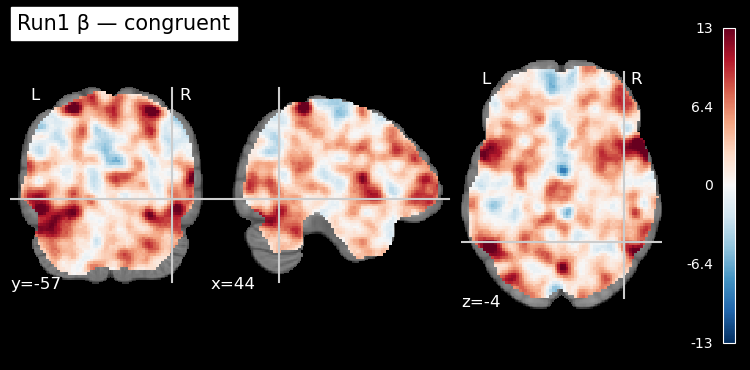

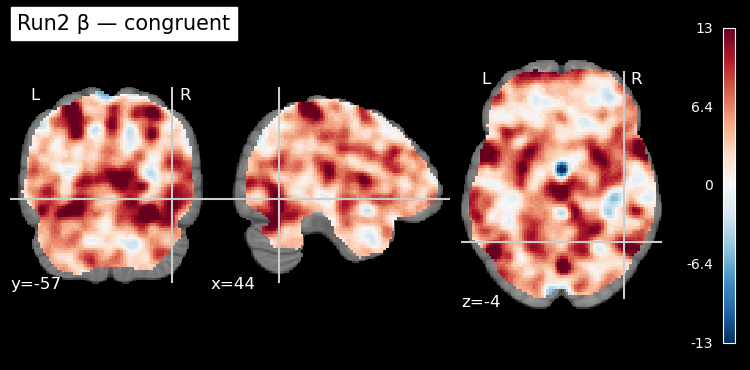

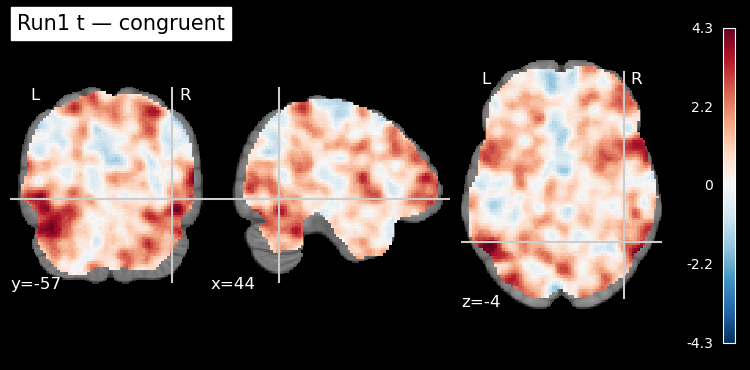

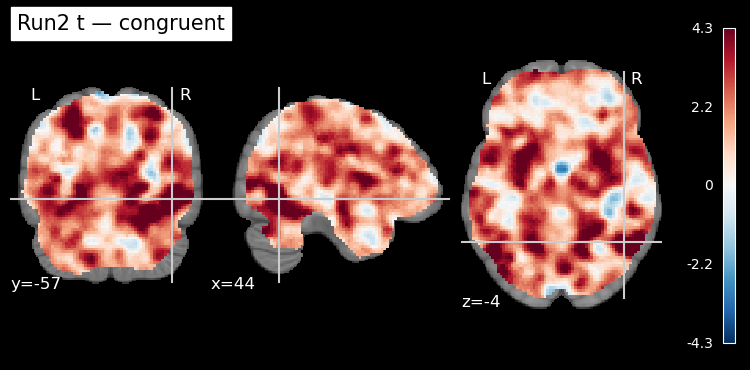

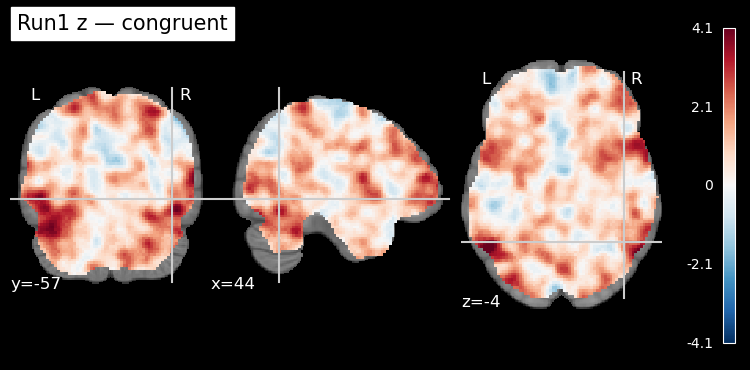

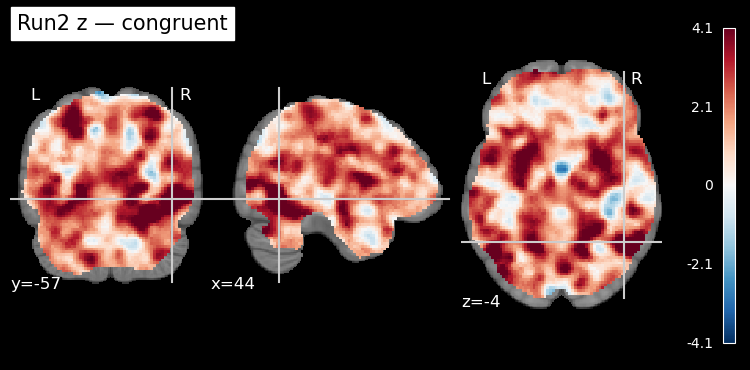

In [ ]:

def robust_vmax(img):   #Upper bound of the colormap. The values above vmax are masked. If None, the max of the image is used.
    data = np.nan_to_num(img.get_fdata(), copy=False)
    return float(np.percentile(np.abs(data), 99))

# set symmetric vmax per map type so runs are comparable
vmax_beta = max(robust_vmax(beta1), robust_vmax(beta2))
vmax_t    = max(robust_vmax(tmap1),  robust_vmax(tmap2))
vmax_z    = max(robust_vmax(zmap1),  robust_vmax(zmap2))

# Auto cut coordinates on run 1 z-map (works well in practice)
cut_coords = plotting.find_xyz_cut_coords(zmap1,mask_img=None, activation_threshold=None)    # Find the center of the largest activation connected component. nilearn.plotting.find_xyz_cut_coords(img, mask_img=None, activation_threshold=None)

# β (effect size): "how big is the effect?"
plotting.plot_stat_map(beta1, bg_img=bg, title=f'Run1 β — {contrast_str}',
                       vmax=vmax_beta, symmetric_cbar=True, cut_coords=cut_coords)
plotting.plot_stat_map(beta2, bg_img=bg, title=f'Run2 β — {contrast_str}',
                       vmax=vmax_beta, symmetric_cbar=True, cut_coords=cut_coords)

# t-map: β / SE(β)
plotting.plot_stat_map(tmap1, bg_img=bg, title=f'Run1 t — {contrast_str}',
                       vmax=vmax_t, symmetric_cbar=True, cut_coords=cut_coords)
plotting.plot_stat_map(tmap2, bg_img=bg, title=f'Run2 t — {contrast_str}',
                       vmax=vmax_t, symmetric_cbar=True, cut_coords=cut_coords)

# z-map: standardized t
plotting.plot_stat_map(zmap1, bg_img=bg, title=f'Run1 z — {contrast_str}',
                       vmax=vmax_z, symmetric_cbar=True, cut_coords=cut_coords)
plotting.plot_stat_map(zmap2, bg_img=bg, title=f'Run2 z — {contrast_str}',
                       vmax=vmax_z, symmetric_cbar=True, cut_coords=cut_coords)
plotting.show()

> **Reading these:**

> ### *β maps* show where the effect is large; *t/z maps* show where it’s large **and** precise (statistically reliable). *p maps* are usually overlaid as thresholds rather than visualized directly.

---

## **Step 5B.4) Thresholded maps**


### 1. Why do we need thresholding?

* A whole-brain fMRI dataset has **tens of thousands of voxels** (often \~50–100k).
* In each voxel we compute a test statistic (t, z, or p).
* If you use a standard cutoff (say, p < 0.05) **without correction**, then by chance alone \~5% of voxels (thousands!) will look “active” even if there’s no true effect.
  → That’s the **multiple comparisons problem**.

👉 **Thresholding** corrects for this problem: it controls how many false positives you expect, while still letting you find real effects.

---

### 2. Different types of thresholding

#### (a) **Voxelwise uncorrected threshold**

* Apply a cutoff directly to each voxel’s statistic, e.g. Z > 3.1 (≈ p < 0.001 uncorrected).
* Pros: very sensitive (you see weak effects).
* Cons: many false positives if you don’t correct for the number of voxels.
* Usually used **only for QC or illustrative purposes**, not final reporting.

---

#### (b) **FDR correction (False Discovery Rate)**

 ##### 🔍 **How Benjamini–Hochberg FDR Works (Readable Formulas)**

Suppose we have **V** voxels, each with a p-value:
$$
[
p_1, p_2, \dots, p_V
]
$$
###### **Step 1 — Sort the p-values**
$$
[
p_{(1)} \le p_{(2)} \le \dots \le p_{(V)}
]
$$
Each has rank (i = 1, 2, ..., V).

---

###### **Step 2 — Compute the BH thresholds**

For each rank (i):
$$
[
\text{BH threshold}_i = \frac{i}{V} \cdot \alpha
]
$$
Where:
$$
* (V) = total number of voxels
$$
$$
* (\alpha) = FDR level (e.g., 0.05)
$$
---

###### **Step 3 — Find the largest index (k)** such that:
$$
[
p_{(k)} \le \frac{k}{V} \cdot \alpha
]
$$
This means the p-value lies below the BH line.

---

###### **Step 4 — Declare all p-values up to that point significant:**
$$
[
p_{(1)}, p_{(2)}, ..., p_{(k)}
]
$$
These voxels are “active” under FDR control.

* Controls the **expected proportion of false positives among all suprathreshold voxels**.
* Example: FDR q < 0.05 → among the voxels you call “significant,” about 5% may be false discoveries.
* Less conservative than FWE (allows more hits).
* Often used when you want a balance between sensitivity and specificity.

👉 Output = **FDR-corrected map**: only voxels with p-values below the adaptive FDR threshold survive.

---

#### (c) **FWE correction (Family-Wise Error)**

* Controls the **probability of making *any* false positive across the whole brain**.
* Much stricter than FDR.
* Based on Random Field Theory, permutations, or Bonferroni-type adjustments.
* Example: FWE p < 0.05 → the chance of even 1 false activation across the brain is <5%.

👉 Output = **FWE-corrected map**: very reliable activations, but you might miss weaker true effects.

---

#### (d) **Cluster-level correction**

* Idea: true activations usually form clusters of neighboring voxels, while noise is “salt-and-pepper.”

* Steps:

  1. Set a **cluster-forming threshold** (e.g., voxelwise Z > 3.1 uncorrected).
  2. Find contiguous clusters of voxels above that threshold.
  3. Keep only clusters larger than expected under null (cluster-size correction).

* Pros: more sensitive to spatially extended but weak activations.

* Cons: depends on cluster-forming threshold; can miss small but real focal activations.

👉 Output = **Cluster-corrected map**: shows only big-enough clusters likely not due to chance.

---

#### (e) **Permutation / non-parametric correction** (bonus)

* Uses **resampling (permuting condition labels)** to build an empirical null distribution of maximum statistics or cluster sizes.
* Makes minimal assumptions about noise.
* Gold-standard for small-sample or non-Gaussian data.
* Tools: FSL *randomise*, Nilearn’s non-parametric functions, etc.

---

### 3. When to use each

* **QC / exploratory:** Uncorrected Z > 2.3 or 3.1 (look at patterns).
* **Standard single-subject:** FDR correction (voxelwise) or cluster correction.
* **Group-level reporting (publications):** FWE or cluster-level (permutation recommended).
* **High-stakes / clinical:** FWE voxelwise.

---

### 4. Visual summary

| Threshold type  | Controls                          | Pros                             | Cons                                             | Typical use                                 |
| --------------- | --------------------------------- | -------------------------------- | ------------------------------------------------ | ------------------------------------------- |
| **Uncorrected** | Nothing                           | Very sensitive, see patterns     | Many false positives                             | QC, exploration                             |
| **FDR**         | % false discoveries among hits    | Balanced sensitivity/specificity | Still some false positives                       | Single-subject, exploratory                 |
| **FWE**         | Any false positive in whole brain | Very reliable                    | Very conservative, misses weak effects           | Group results, publications                 |
| **Cluster**     | Cluster-level false positives     | Detects broad weak activations   | Depends on threshold choice, may miss small foci | Group results, subject-level with low power |
| **Permutation** | Empirical null distribution       | Few assumptions, robust          | Computationally heavy                            | Gold-standard confirmation                  |

---

✅ **Key idea**: Thresholding is about balancing **sensitivity** (finding real effects) and **specificity** (avoiding false positives). You always need to report *what correction you used*, because it directly affects how strong your claims are.




**What this does:** applies a **voxelwise cluster-forming threshold** (e.g., Z>3.1) and keeps clusters of at least `k` voxels. This is *not* FDR/FWE—this is a cluster-based display threshold often used for teaching/exploration.




 ## ✅ ** Explanation of nilearn.glm.threshold_stats_img**

`threshold_stats_img()` applies **voxel-level** and **optional cluster-level** thresholding to a statistical map (z, t, or p map). It is mainly used for *display* and *exploration*, not formal correction (unless `height_control='fdr'` or `'bonferroni'` is used).

---

## 🔍 Function Signature 

```python
nilearn.glm.threshold_stats_img(
    stat_img=None,
    mask_img=None,
    alpha=0.001,
    threshold=3.0,
    height_control='fpr',
    cluster_threshold=0,
    two_sided=True
)
```

---

# ✔ **Argument Explanations **

#### **• stat_img**

The statistical map to be thresholded (e.g., z-map).
Required unless you use `height_control='fpr'` or `None`.

#### **• mask_img**

Optional brain mask.
Defines where thresholding is applied.

---

### **Height Threshold Parameters**

#### **• alpha**

Controls the **voxel-level threshold**.
Its meaning depends on `height_control`:

* If `height_control='fpr'` (default):
  `alpha` is a **p-value threshold**, converted to a **z-threshold** automatically.
  Example: `alpha=0.001 → z ≈ 3.09`.

* If `height_control='fdr'`:
  `alpha` is a **q-value** (FDR false discovery rate).

* If `height_control='bonferroni'`:
  `alpha` is the **family-wise error rate**.

* If `height_control=None`:
  `alpha` is ignored; you must specify `threshold` manually.

---

#### **• threshold**

A **manual z-value threshold**, only used when:

```python
height_control is None
```

Example:

```python
threshold=3.0  # keep only voxels with z > 3
```

---

### **Cluster Threshold Parameter**

#### **• cluster_threshold**

Minimum size (in voxels) for a cluster to be kept.
Example: `cluster_threshold=20` keeps only clusters ≥20 voxels.

This performs **cluster-size filtering**, not cluster-level inference.

---

### **Two-sided Option**

#### **• two_sided**

Whether the test is two-sided (default `True`).

* `True` → thresholds positive and negative activations symmetrically
* `False` → only positive tail

---

## 🎯 **What the function returns**

### **• thresholded_map**

A new NIfTI image where:

1. Voxels failing the **voxel-level threshold** are removed
2. Clusters smaller than **cluster_threshold** are also removed

This map is intended for clean visualization of activation patterns.

            threshold: float
              The voxel-level threshold used actually.
                                       

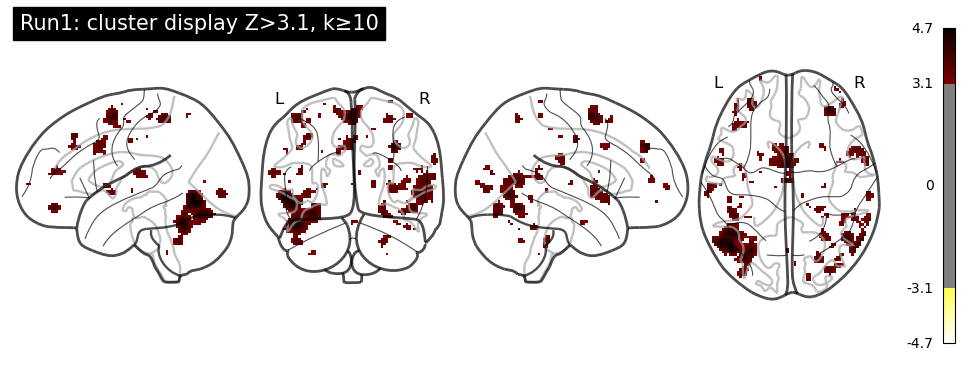

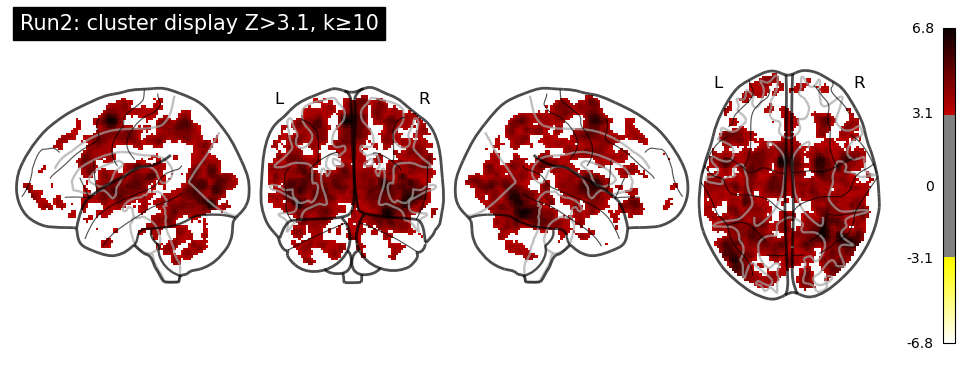

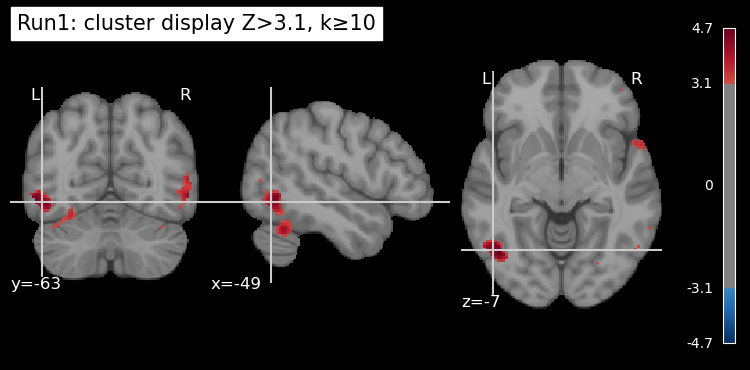

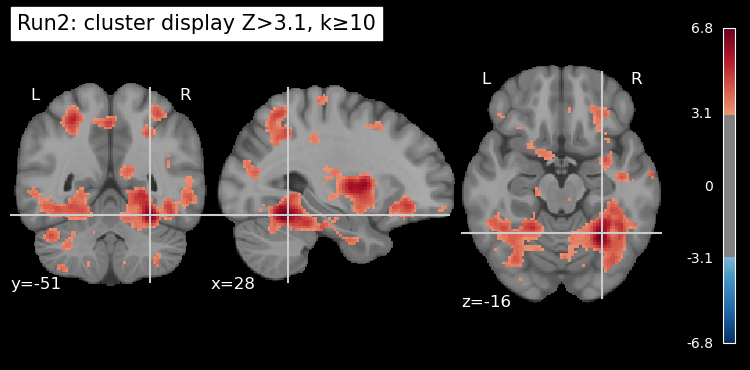

In [ ]:
from nilearn.glm import thresholding

# Cluster-forming Z threshold and min cluster size
z_voxel_thr    = 3.1      # ~p<0.001 (uncorrected)
min_cluster_sz = 10       # voxels

thr_img1, _ = thresholding.threshold_stats_img(
    zmap1, alpha=0.05, height_control=None,  # no voxelwise multiple-comparison correction
    two_sided=True, threshold=z_voxel_thr, cluster_threshold=min_cluster_sz
)
thr_img2, _ = thresholding.threshold_stats_img(
    zmap2, alpha=0.05, height_control=None,
    two_sided=True, threshold=z_voxel_thr, cluster_threshold=min_cluster_sz
)

coords1 = plotting.find_xyz_cut_coords(thr_img1)
coords2 = plotting.find_xyz_cut_coords(thr_img2)

plotting.plot_glass_brain(zmap1, threshold=z_voxel_thr, colorbar=True, display_mode='lyrz',
                          title=f'Run1: cluster display Z>{z_voxel_thr}, k≥{min_cluster_sz}',
                          symmetric_cbar=True)
plotting.plot_glass_brain(zmap2, threshold=z_voxel_thr, colorbar=True, display_mode='lyrz',
                          title=f'Run2: cluster display Z>{z_voxel_thr}, k≥{min_cluster_sz}',
                          symmetric_cbar=True)

plotting.plot_stat_map(zmap1, bg_img=bg, threshold=z_voxel_thr, display_mode='ortho',
                       cut_coords=coords1, symmetric_cbar=True,
                       title=f'Run1: cluster display Z>{z_voxel_thr}, k≥{min_cluster_sz}')
plotting.plot_stat_map(zmap2, bg_img=bg, threshold=z_voxel_thr, display_mode='ortho',
                       cut_coords=coords2, symmetric_cbar=True,
                       title=f'Run2: cluster display Z>{z_voxel_thr}, k≥{min_cluster_sz}')
plotting.show()

> ### **Alternative:** if you want **voxelwise FDR/FWE correction**, change `height_control` to `'fdr'` or `'fwe'` and **remove** the fixed `threshold=` (let Nilearn compute the cutoff).

---

## **Step 5B.5) Fixed-effects (combine the two runs within subject)**

**What this does:** fuses run-wise results into a single subject map by weighting effects by their variance.

* **Input:** per-run **effect-size** maps and **effect-variance** maps.

* **Output:** combined **effect**, **variance**, and **z** maps.

C:\Users\Saye\AppData\Local\Temp\ipykernel_3028\2249843446.py:3: DeprecationWarning: The behavior of this function will be changed in release 0.13 to have an additional return value 'fixed_fx_z_score_img' by default. Please set return_z_score to True.
  fx_eff, fx_var, fx_z = compute_fixed_effects([beta1, beta2], [var1, var2], mask=None)


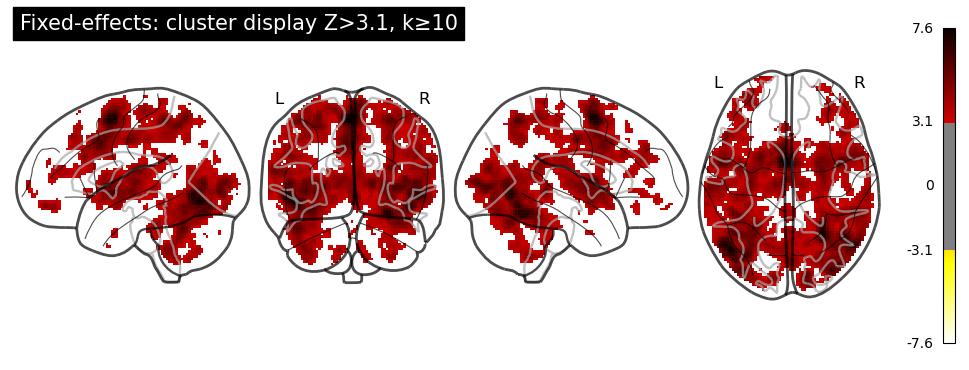

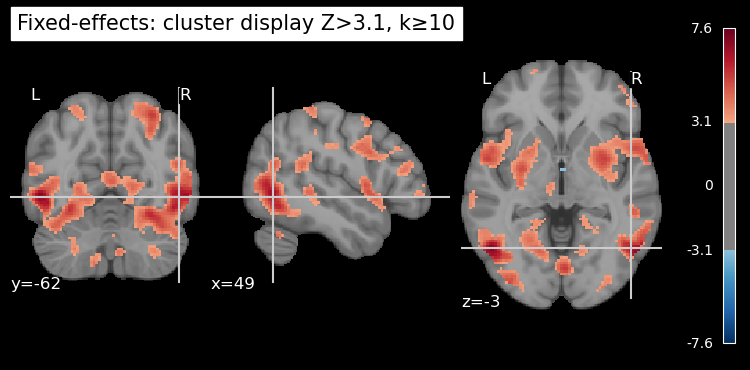

In [ ]:
from nilearn.glm.contrasts import compute_fixed_effects

fx_eff, fx_var, fx_z = compute_fixed_effects([beta1, beta2], [var1, var2], mask=None)

# Display threshold (use same cluster display rule for comparability)
fx_thr_img, _ = thresholding.threshold_stats_img(
    fx_z, alpha=0.05, height_control=None,
    two_sided=True, threshold=z_voxel_thr, cluster_threshold=min_cluster_sz
)
fx_coords = plotting.find_xyz_cut_coords(fx_thr_img)

vmax_fx = robust_vmax(fx_z)
plotting.plot_glass_brain(fx_z, threshold=z_voxel_thr, colorbar=True, display_mode='lyrz',
                          title=f'Fixed-effects: cluster display Z>{z_voxel_thr}, k≥{min_cluster_sz}',
                          symmetric_cbar=True)
plotting.plot_stat_map(fx_z, bg_img=bg, threshold=z_voxel_thr, display_mode='ortho',
                       cut_coords=fx_coords, symmetric_cbar=True,
                       title=f'Fixed-effects: cluster display Z>{z_voxel_thr}, k≥{min_cluster_sz}')
plotting.show()

## Recap: what each map “tells you”

* **β (effect\_size)** → *How big is the effect?* (magnitude)
  Use when comparing effect sizes across conditions/ROIs; not corrected for uncertainty.

* **Var(β) (effect\_variance)** → *How uncertain is β?*
  Large variance = noisy/unstable estimates; helps interpret why t/z might be small.

* **t map (stat)** → *How strong is β relative to its uncertainty?*
  Primary test statistic in many GLMs; used for voxelwise inference.

* **z map (z\_score)** → *Standardized t* for easier thresholding/comparison; widely reported.

* **p map (p\_value)** → *Uncorrected voxelwise p-values*; useful for QC or custom corrections, but for final claims prefer FDR/FWE/cluster-corrected results.

In [ ]:
import numpy as np
from nilearn import plotting
from nilearn.glm import thresholding

# 1) How strong is the unthresholded Z?
zs1 = zmap1.get_fdata()
zs2 = zmap2.get_fdata()
print("Run1 Z min/max:", float(np.nanmin(zs1)), float(np.nanmax(zs1)))
print("Run2 Z min/max:", float(np.nanmin(zs2)), float(np.nanmax(zs2)))

# 2) What FDR threshold did you get vs peaks?
_, thr1 = thresholding.threshold_stats_img(
    zmap1, alpha=0.05, height_control=None, cluster_threshold=10, two_sided=True, threshold=3.1
)
_, thr2 = thresholding.threshold_stats_img(
    zmap2, alpha=0.05, height_control=None, cluster_threshold=10, two_sided=True, threshold=3.1
)
print("Run1 cluster threshold (Z>3.1, k>=10):", thr1, "| Run2 cluster threshold (Z>3.1, k>=10):", thr2)

# 3) How many voxels would survive common cutoffs?
def count_supra(z, thr):
    return int(np.sum(np.abs(z) > thr))

print("Run1 voxels |Z|>2.3:", count_supra(zs1, 2.3), " |Z|>3.1:", count_supra(zs1, 3.1))
print("Run2 voxels |Z|>2.3:", count_supra(zs2, 2.3), " |Z|>3.1:", count_supra(zs2, 3.1))

# 4) Do you actually have trials per condition in Run 1?
print(events1_clean['trial_type'].value_counts())
print(events2_clean['trial_type'].value_counts())


Run1 Z min/max: -3.3071736908214877 4.748335052273068
Run2 Z min/max: -3.82481484160258 6.777944485452429
Run1 cluster threshold (Z>3.1, k>=10): 3.1 | Run2 cluster threshold (Z>3.1, k>=10): 3.1
Run1 voxels |Z|>2.3: 13398  |Z|>3.1: 2212
Run2 voxels |Z|>2.3: 64163  |Z|>3.1: 27650
trial_type
congruent      12
incongruent    12
Name: count, dtype: int64
trial_type
congruent      12
incongruent    12
Name: count, dtype: int64


## What you’ve accomplished

* You instantiated a **first-level GLM** for **each run**, including **confounds** (motion 24HMP ± extras) and **cosine drifts**.
* You defined **contrasts** by **name**, computed **Z-maps**/**effect sizes**, and **thresholded** them.
* You optionally **combined runs** using a principled **fixed-effects** approach.

From here you can:

* Repeat for additional contrasts (e.g., each condition vs baseline).
* Export maps and a brief methods blurb (TR, high-pass, noise model, confounds strategy, thresholds).
* Proceed to **functional connectivity** (ROI↔ROI and seed-based), reusing the **same confounds** in your maskers.